In [27]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS
        self.char2index = {}
        self.char2count = {}
        self.index2char = {0: "SOS", 1: "EOS"}
        self.n_chars = 2

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
        for char in sentence:
            if char not in self.char2index:
                self.char2index[char] = self.n_chars
                self.char2count[char] = 1
                self.index2char[self.n_chars] = char
                self.n_chars += 1
            else:
                self.char2count[char] += 1

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [43]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-z]+", r" ", s)
    s.strip()
    return s

In [111]:
def readLangs():
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('/Users/uno/cs410/cs410explain/training/paper/SlangIJCNLP/train.tsv', encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    examples = [[normalizeString(s) for s in l.split('\t')[:3]] for l in lines]
    input_lang = Lang('slang')
    output_lang = Lang('explain')

    return input_lang, output_lang, examples

In [47]:
MAX_SENTENCE_LENGTH = 20
MAX_WORD_LENGTH = 10

def filterExample(p):
    return len(p) == 3 and \
        len(p[2].split(' ')) < MAX_SENTENCE_LENGTH and \
        len(p[1].split(' ')) < MAX_SENTENCE_LENGTH and \
        len(p[0]) < MAX_WORD_LENGTH


def filterExamples(examples):
    return [example for example in examples if filterExample(example)]

In [112]:
def prepareData():
    input_lang, output_lang, examples = readLangs()
    print("Read %s sentence examples" % len(examples))
    examples = filterExamples(examples)
    print("Trimmed to %s sentence pairs" % len(examples))
    print("Counting words...")
    for example in examples:
        input_lang.addSentence(example[2])
        output_lang.addSentence(example[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, examples


input_lang, output_lang, examples = prepareData()
print(random.choice(examples))

Reading lines...
Read 911821 sentence examples
Trimmed to 222105 sentence pairs
Counting words...
Counted words:
slang 115758
explain 63337
['krimbin ', 'when one does not leave another alone', 'dude benecio was totally krimbin me last night called my cell like times ']


In [49]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [95]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, 
                 context_max_length=MAX_SENTENCE_LENGTH,
                 character_max_length=MAX_WORD_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, context_max_length)
        self.char_attn = nn.Linear(self.hidden_size * 2, character_max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 3, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs, char_encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        cat = torch.cat((embedded[0], hidden[0]), 1)
        attn_weights = F.softmax(
            self.attn(cat), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        
        char_attn_weights = F.softmax(
            self.char_attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        char_attn_applied = torch.bmm(char_attn_weights.unsqueeze(0),
                                      char_encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0], char_attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [52]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def charIndexesFromSentence(lang, sentence):
    return [lang.char2index[char] for char in sentence]

def charTensorFromSentence(lang, sentence):
    indexes = charIndexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1) 

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[2])
    char_input_tensor = charTensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, char_input_tensor, target_tensor)

In [54]:
example = random.choice(examples)
print(example)
print(tensorsFromPair(example))

['dolen', ' nickname for any closet bisexual girl with decent hooters ', 'yo pimpmasta l stacy wont admit about that time she wuz tradin toungues wit brittani what a dolen ']
(tensor([[ 111],
        [3672],
        [1748],
        [3673],
        [2546],
        [3674],
        [1087],
        [  72],
        [ 387],
        [  12],
        [3675],
        [3676],
        [3677],
        [2085],
        [3678],
        [ 165],
        [  17],
        [3679],
        [  11],
        [   1]]), tensor([[18],
        [ 7],
        [12],
        [ 4],
        [10],
        [ 1]]), tensor([[   2],
        [1024],
        [  69],
        [  91],
        [3819],
        [2405],
        [ 263],
        [  74],
        [ 813],
        [3820],
        [   2],
        [   1]]))


In [93]:
teacher_forcing_ratio = 0.5

def train(input_tensor, char_input_tensor, target_tensor, encoder, char_encoder, decoder, combiner,
          encoder_optimizer, char_encoder_optimizer, decoder_optimizer, combiner_optimizer, 
          criterion, context_max_length=MAX_SENTENCE_LENGTH, character_max_length=MAX_WORD_LENGTH):
    encoder_hidden = encoder.initHidden()
    char_encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    char_encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    combiner_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    char_input_length = char_input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(context_max_length, encoder.hidden_size, device=device)
    char_encoder_outputs = torch.zeros(character_max_length, char_encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    for ei in range(char_input_length):
        char_encoder_output, char_encoder_hidden = char_encoder(
            char_input_tensor[ei], char_encoder_hidden)
        char_encoder_outputs[ei] = char_encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = combiner(torch.cat((encoder_hidden[0], char_encoder_hidden[0]), 1)).view(1,1,-1)

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs, char_encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs, char_encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
    decoder_optimizer.zero_grad()
    combiner_optimizer.zero_grad()

    return loss.item() / target_length

In [56]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [79]:
def trainIters(encoder, char_encoder, decoder, combiner, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    char_encoder_optimizer = optim.SGD(char_encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    combiner_optimizer = optim.SGD(combiner.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(examples))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        char_input_tensor = training_pair[1]
        target_tensor = training_pair[2]

        loss = train(input_tensor, char_input_tensor, target_tensor, encoder, char_encoder, decoder, combiner,
                     encoder_optimizer, char_encoder_optimizer, decoder_optimizer, combiner_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [58]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

0m 0s (- 0m 0s) (1 10%) 9.8890
0m 0s (- 0m 0s) (2 20%) 9.8523
0m 0s (- 0m 0s) (3 30%) 9.8982
0m 0s (- 0m 0s) (4 40%) 9.8085
0m 0s (- 0m 0s) (5 50%) 9.7204
0m 0s (- 0m 0s) (6 60%) 9.8675
0m 0s (- 0m 0s) (7 70%) 9.6991
0m 0s (- 0m 0s) (8 80%) 9.7107
0m 0s (- 0m 0s) (9 90%) 9.7614
0m 0s (- 0m 0s) (10 100%) 9.7985


<Figure size 432x288 with 0 Axes>

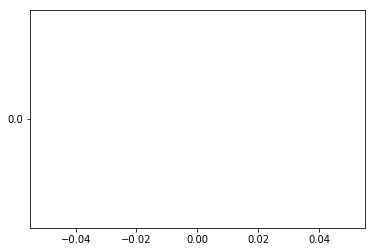

In [96]:
hidden_size = 10
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
encoder2 = EncoderRNN(input_lang.n_chars, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
combiner = nn.Linear(hidden_size * 2, hidden_size)
trainIters(encoder1, encoder2, attn_decoder1, combiner, 10, print_every=1)

In [106]:
def evaluate(encoder, char_encoder, decoder, combiner, sentence, target_words,
             context_max_length=MAX_SENTENCE_LENGTH, character_max_length=MAX_WORD_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        char_input_tensor = charTensorFromSentence(input_lang, target_words)
        char_input_length = char_input_tensor.size()[0]
        
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(context_max_length, encoder.hidden_size, device=device)
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        
        char_encoder_hidden = char_encoder.initHidden()
        char_encoder_outputs = torch.zeros(character_max_length, char_encoder.hidden_size, device=device)
        for ei in range(char_input_length):
            char_encoder_output, char_encoder_hidden = char_encoder(char_input_tensor[ei],
                                                                    char_encoder_hidden)
            char_encoder_outputs[ei] += char_encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = combiner(torch.cat((encoder_hidden[0], char_encoder_hidden[0]), 1)).view(1,1,-1)

        decoded_words = []
        decoder_attentions = torch.zeros(context_max_length, context_max_length)

        for di in range(context_max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs, char_encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [110]:
def evaluateRandomly(encoder, char_encoder, decoder, combiner, n=10):
    for i in range(n):
        example = random.choice(examples)
        print('>', example[0])
        print('=', example[1])
        output_words, attentions = evaluate(encoder, char_encoder, decoder, combiner, example[2], example[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [109]:
evaluateRandomly(encoder1, encoder2, attn_decoder1, combiner)

> arrey arrey stop eating all my poptarts surprised arreyy you almost gave me a heart attack man 
= an indian exclamation of surprise anger or frustration exasperation 
< bears aerodynamic attends minds minds lowe disgust maize kinda kinda kinda kinda kinda kinda kinda alliteration attends dkm dkm maize

> broura aaron s broura follows him wherever he goes 
= the aura surrounding a bro such that all of the bro s immediate surroundings also become broified 
< chilangos attends minds minds lowe maize alian dkm dkm maize agro dkm dkm dkm maize agro dkm dkm dkm maize

> chubbler hey that hippie has a sweet chubbler i hope its packed with some dank g 
= a cross between a chillum and a bubbler 
< coat sissy attends dkm minds lowe disgust attends attends attends dkm minds lowe disgust attends dkm minds disconnected differenet differenet

> bob saget last night i got really bored and did a bob saget in the bathroom 
= taking a poop while masturbating and eating a peanut butter and jelly sandwh